In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dask
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:

# Import libraries
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

train_dataframes = []
for i in tqdm(range(1, 3)):
    train_dataframes.append(pd.read_csv(f'data-train/train_data_part_{i}.csv'))
train_data = pd.concat(train_dataframes, ignore_index=True)

# free up memory by deleting the dataframes we no longer need
del train_dataframes

# This code reads the data from a CSV file named "products_data.csv" into a pandas DataFrame
products_data = pd.read_csv('data-train/products_data.csv')

# This code reads the data from a CSV file named "test_data.csv" into a pandas DataFrame
test_data = pd.read_csv('data-train/test_data.csv')


100%|██████████| 2/2 [00:56<00:00, 28.04s/it]
C:\Users\jeann\AppData\Local\Temp\ipykernel_22060\914486963.py:15: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  products_data = pd.read_csv('data-train/products_data.csv')


essayer de réduire train data

In [4]:
columns_to_keep = ['date', 'transaction_id', 'customer_id', 'product_id','quantity']
train_data_rfm = train_data[columns_to_keep]
columns_to_keep = ['product_id', 'product_description', 'department_key', 'sector']
products_data_rfm = products_data[columns_to_keep]

In [5]:
train_data_rfm = train_data_rfm.merge(products_data_rfm, on='product_id', how='left')
train_data_rfm.head()


,date,transaction_id,customer_id,product_id,quantity,product_description,department_key,sector
0,2023-11-15,Transaction_1730125,Household_39,Product_5362,1.0,400G RILLETTES DU MANS CRF EXT,Department_25,PGC
1,2022-07-20,Transaction_1560535,Household_39,Product_67174,2.0,4/4 HARICOT VRT TF SIMPL,Department_14,PGC
2,2022-07-20,Transaction_1560535,Household_39,Product_82254,2.0,350G KNACKS X10 CRF CLASSIC,Department_25,PGC
3,2023-11-15,Transaction_1730125,Household_39,Product_3895,1.0,BK 6X1L LAIT 1/2 ECREME SIMPL,Department_25,PGC
4,2022-07-20,Transaction_1560535,Household_39,Product_34014,1.0,10X100G MOELLEUX 20%MG SIMPL,Department_25,PGC


calcul des valeurs rfm

In [6]:
from datetime import datetime

# Convertir les dates en format datetime si nécessaire
train_data_rfm['date'] = pd.to_datetime(train_data_rfm['date'])

# Dernière date de la transaction dans les données d'entraînement (pour la récence)
latest_date = train_data_rfm['date'].max()

# Récence, Fréquence et Montant pour chaque client
rfm_train = train_data_rfm.groupby('customer_id').agg({
    'date': lambda x: (latest_date - x.max()).days,  # Récence : par rapport a la derniere date d'achat
    'transaction_id': pd.Series.nunique,             # Fréquence : nb de fois ou il a fais ces courses
    'quantity': 'sum'                                # Approximation du Montant avec les quantités : nb d'articles qu'ils prenaits
}).rename(columns={'date': 'recence', 'transaction_id': 'frequence', 'quantity': 'montant'})

# Réinitialiser l'index pour que customer_id soit une colonne normale
rfm_train = rfm_train.reset_index()

print(rfm_train.head())

       customer_id  recence  frequence  montant
0      Household_1        1         24    939.0
1     Household_10       14         44   3544.0
2    Household_100       31          5    238.0
3   Household_1000       19         11    555.0
4  Household_10000       30         17    510.0


Appliquons des seuils de quartiles pour créer les segments RFM basés sur des catégories (bas, moyen, haut)

In [7]:
# Calcul des quartiles pour chaque métrique dans les données d'entraînement
quartiles = rfm_train[['recence', 'frequence', 'montant']].quantile([1/3, 2/3])

# Fonction pour segmenter chaque valeur RFM en fonction des quartiles
def rfm_segment(value, quartile_values):
    if value <= quartile_values[1/3]:
        return 'Bas'
    elif value <= quartile_values[2/3]:
        return 'Moyen'
    else:
        return 'Haut'

# Segmenter les valeurs RFM dans le train et le test
rfm_train['Segment_Recence'] = rfm_train['recence'].apply(rfm_segment, args=(quartiles['recence'],))
rfm_train['Segment_Frequence'] = rfm_train['frequence'].apply(rfm_segment, args=(quartiles['frequence'],))
rfm_train['Segment_Montant'] = rfm_train['montant'].apply(rfm_segment, args=(quartiles['montant'],))

print(rfm_train.head())


       customer_id  recence  frequence  montant Segment_Recence  \
0      Household_1        1         24    939.0             Bas   
1     Household_10       14         44   3544.0           Moyen   
2    Household_100       31          5    238.0           Moyen   
3   Household_1000       19         11    555.0           Moyen   
4  Household_10000       30         17    510.0           Moyen   

  Segment_Frequence Segment_Montant  
0             Moyen           Moyen  
1              Haut            Haut  
2               Bas             Bas  
3               Bas             Bas  
4             Moyen             Bas  


création de segment complémentaire

In [17]:
rfm_train["FM"] = rfm_train.apply(
    lambda x: "FM Faible" if x["Segment_Frequence"] == "Bas" and x["Segment_Montant"] == "Bas"
    else ("FM Faible" if x["Segment_Frequence"] == "Bas" and x["Segment_Montant"] == "Moyen"
    else ("FM Moyenne" if x["Segment_Frequence"] == "Bas" and x["Segment_Montant"] == "Haut"
    else ("FM Faible" if x["Segment_Frequence"] == "Moyen" and x["Segment_Montant"] == "Bas"
    else ("FM Moyenne" if x["Segment_Frequence"] == "Moyen" and x["Segment_Montant"] == "Moyen"
    else ("FM Forte" if x["Segment_Frequence"] == "Moyen" and x["Segment_Montant"] == "Haut"
    else ("FM Moyenne" if x["Segment_Frequence"] == "Haut" and x["Segment_Montant"] == "Bas"
    else ("FM Forte" if x["Segment_Frequence"] == "Haut" and x["Segment_Montant"] == "Moyen"
    else "FM Forte"))))))),
    axis=1
)
rfm_train.head()

,customer_id,recence,frequence,montant,Segment_Recence,Segment_Frequence,Segment_Montant,FM
0,Household_1,1,24,939.0,Bas,Moyen,Moyen,FM Moyenne
1,Household_10,14,44,3544.0,Moyen,Haut,Haut,FM Forte
2,Household_100,31,5,238.0,Moyen,Bas,Bas,FM Faible
3,Household_1000,19,11,555.0,Moyen,Bas,Bas,FM Faible
4,Household_10000,30,17,510.0,Moyen,Moyen,Bas,FM Faible


In [18]:
rfm_train["RFM"] = rfm_train.apply(
    lambda x: "RFM1" if x["FM"] == "FM Faible" and x["Segment_Recence"] == "Haut"
    else ("RFM2" if x["FM"] == "FM Faible" and x["Segment_Recence"] == "Moyen"
    else ("RFM3" if x["FM"] == "FM Faible" and x["Segment_Recence"] == "Bas"
    else ("RFM4" if x["FM"] == "FM Moyenne" and x["Segment_Recence"] == "Haut"
    else ("RFM5" if x["FM"] == "FM Moyenne" and x["Segment_Recence"] == "Moyen"
    else ("RFM6" if x["FM"] == "FM Moyenne" and x["Segment_Recence"] == "Bas"
    else ("RFM7" if x["FM"] == "FM Forte" and x["Segment_Recence"] == "Haut"
    else ("RFM8" if x["FM"] == "FM Forte" and x["Segment_Recence"] == "Moyen"
    else "RFM9"))))))),
    axis=1)

# Vérifiez les résultats
print(rfm_train.head())

       customer_id  recence  frequence  montant Segment_Recence  \
0      Household_1        1         24    939.0             Bas   
1     Household_10       14         44   3544.0           Moyen   
2    Household_100       31          5    238.0           Moyen   
3   Household_1000       19         11    555.0           Moyen   
4  Household_10000       30         17    510.0           Moyen   

  Segment_Frequence Segment_Montant          FM   RFM  
0             Moyen           Moyen  FM Moyenne  RFM6  
1              Haut            Haut    FM Forte  RFM8  
2               Bas             Bas   FM Faible  RFM2  
3               Bas             Bas   FM Faible  RFM2  
4             Moyen             Bas   FM Faible  RFM2  


regroupement par rfm semblable

In [23]:
rfm_train["Segment_RFM"]= rfm_train.apply(
    lambda x :
    "Very Good Customers" if x["RFM"] in ["RFM9", "RFM8"]
    else("Good Customers" if x["RFM"] in ["RFM6", "RFM5"]
    else("Loss of Momentum" if x["RFM"] in ["RFM7", "RFM4"]
    else("Small Consumers" if x["RFM"] in ["RFM2", "RFM3"]
    else("Weak Customers")))),
    axis=1)
rfm_train.head()

,customer_id,recence,frequence,montant,Segment_Recence,Segment_Frequence,Segment_Montant,FM,RFM,Segment_RFM
0,Household_1,1,24,939.0,Bas,Moyen,Moyen,FM Moyenne,RFM6,Good Customers
1,Household_10,14,44,3544.0,Moyen,Haut,Haut,FM Forte,RFM8,Very Good Customers
2,Household_100,31,5,238.0,Moyen,Bas,Bas,FM Faible,RFM2,Small Consumers
3,Household_1000,19,11,555.0,Moyen,Bas,Bas,FM Faible,RFM2,Small Consumers
4,Household_10000,30,17,510.0,Moyen,Moyen,Bas,FM Faible,RFM2,Small Consumers


Comptez les clients dans chaque segment RFM pour voir la répartition

In [20]:
recap_RFM= rfm_train.groupby('Segment_RFM', as_index=False).agg(
    number_of_customers= ('customer_id', 'size'),
    percentage_of_customers= ('customer_id', lambda x: (x.count()*100)/7688),
    average_recency= ('recence', 'mean'),
    average_frequency= ('frequence', 'mean'),
    average_monetary= ('montant', 'mean')
)
print(recap_RFM)

           Segment_RFM  number_of_customers  percentage_of_customers  \
0       Good Customers                 2426                31.555671   
1     Loss of Momentum                 2693                35.028616   
2      Small Consumers                 4262                55.437045   
3  Very Good Customers                 6645                86.433403   
4       Weak Customers                 3974                51.690947   

   average_recency  average_frequency  average_monetary  
0        13.183842          22.111294        900.441880  
1        86.017081          28.494616       1427.809572  
2        14.332473          11.316049        454.202722  
3        10.166290          53.313619       2394.313442  
4       131.146452           9.484147        447.568697  


#######################################      changement de partie, ACP pour chaque segment      ####################################

In [24]:
data_train_product= rfm_train.merge(train_data[['customer_id', 'product_id']], on='customer_id', how='left')
train_data_secteur = data_train_product.merge(products_data[['product_id', 'sector']], on='product_id', how='left')
print(train_data_secteur.head())

   customer_id  recence  frequence  montant Segment_Recence Segment_Frequence  \
0  Household_1        1         24    939.0             Bas             Moyen   
1  Household_1        1         24    939.0             Bas             Moyen   
2  Household_1        1         24    939.0             Bas             Moyen   
3  Household_1        1         24    939.0             Bas             Moyen   
4  Household_1        1         24    939.0             Bas             Moyen   

  Segment_Montant          FM   RFM     Segment_RFM     product_id sector  
0           Moyen  FM Moyenne  RFM6  Good Customers   Product_8163    PGC  
1           Moyen  FM Moyenne  RFM6  Good Customers  Product_38646    PGC  
2           Moyen  FM Moyenne  RFM6  Good Customers  Product_34782    PGC  
3           Moyen  FM Moyenne  RFM6  Good Customers  Product_23625    PGC  
4           Moyen  FM Moyenne  RFM6  Good Customers  Product_47042    PGC  


In [22]:
# 2. Créer une table de fréquence par secteur pour chaque client
# Compter le nombre d'achats par secteur pour chaque client
client_secteur_freq = train_data_secteur.groupby(['customer_id', 'sector']).size().unstack(fill_value=0)
print(client_secteur_freq.head())

sector           ACTIVITES PERIPHERIQUES  BAZAR  EPCS   PGC  \
customer_id                                                   
Household_1                            0     12     0   602   
Household_10                           0     16     0  2006   
Household_100                          0      2     0   155   
Household_1000                         0      2     0   327   
Household_10000                        0      2     0   344   

sector           PRODUITS FRAIS TRANSFORMATION  TEXTILE  
customer_id                                              
Household_1                                149        0  
Household_10                               428        0  
Household_100                                8        0  
Household_1000                             105        2  
Household_10000                             42        0  


In [27]:
rfm_train_with_segments = rfm_train.merge(train_data_secteur[['customer_id', 'Segment_RFM']], on='customer_id', how='left')
print(rfm_train_with_segments)

             customer_id  recence  frequence  montant Segment_Recence  \
0            Household_1        1         24    939.0             Bas   
1            Household_1        1         24    939.0             Bas   
2            Household_1        1         24    939.0             Bas   
3            Household_1        1         24    939.0             Bas   
4            Household_1        1         24    939.0             Bas   
...                  ...      ...        ...      ...             ...   
17523934  Household_9999        6         25    945.0             Bas   
17523935  Household_9999        6         25    945.0             Bas   
17523936  Household_9999        6         25    945.0             Bas   
17523937  Household_9999        6         25    945.0             Bas   
17523938  Household_9999        6         25    945.0             Bas   

         Segment_Frequence Segment_Montant          FM   RFM   Segment_RFM_x  \
0                    Moyen           Moyen 

In [ ]:
# 3. Joindre les segments RFM aux données de fréquence par secteur
# Ajouter le segment RFM au tableau de fréquence par secteur
rfm_train_with_segments = rfm_train.merge(train_data_secteur[['customer_id', 'Segment_RFM']], on='customer_id', how='left')
client_secteur_freq = client_secteur_freq.merge(rfm_train_with_segments[['customer_id', 'Segment_RFM_x']], 
                                                on='customer_id', how='left')



ACP pour le segment RFM : Good Customers


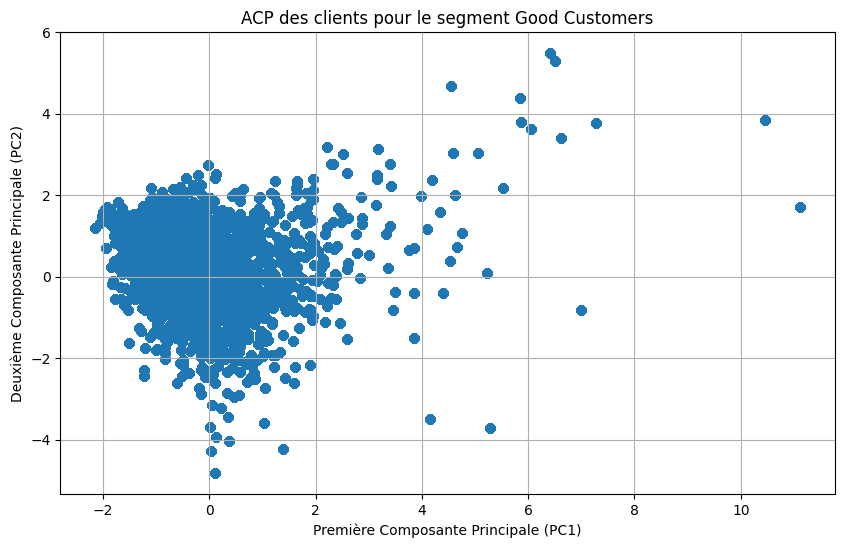

Variance expliquée par chaque composante: [0.27746774 0.22094511]
Variance totale expliquée: 0.49841284834651234

ACP pour le segment RFM : Very Good Customers


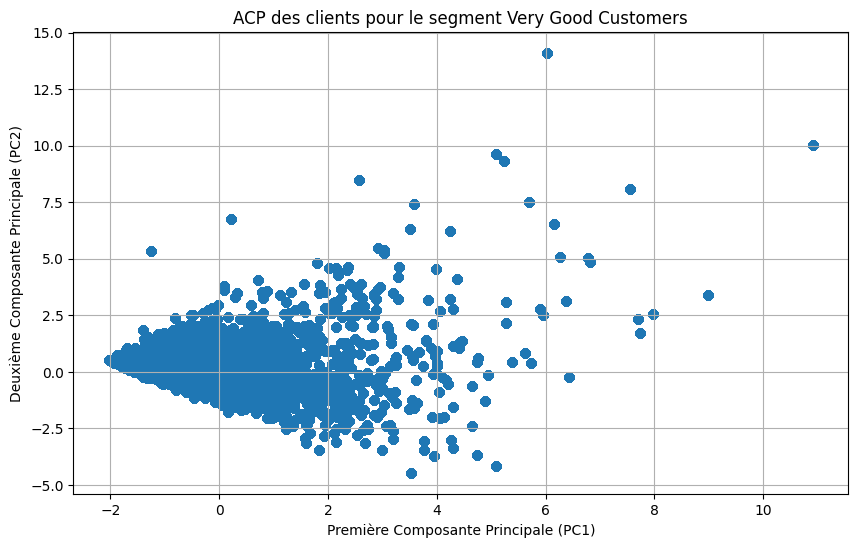

Variance expliquée par chaque composante: [0.35783995 0.17650713]
Variance totale expliquée: 0.53434707200776

ACP pour le segment RFM : Small Consumers


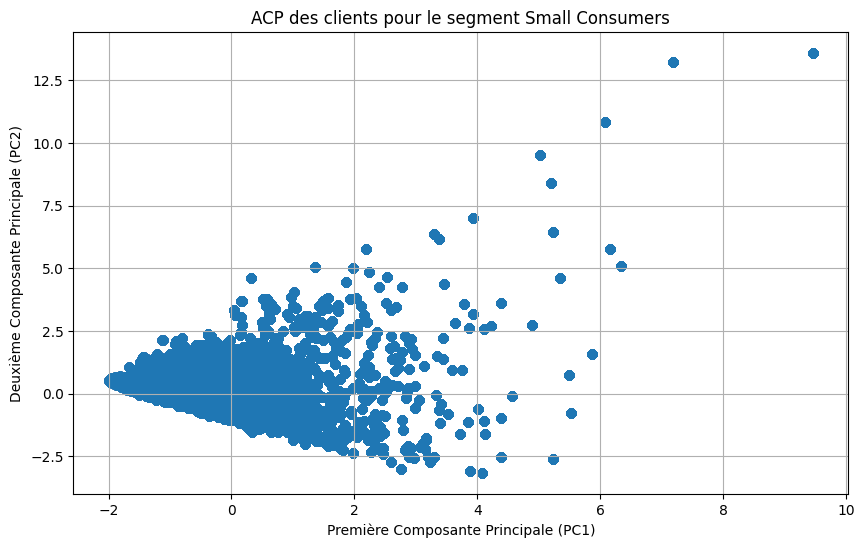

Variance expliquée par chaque composante: [0.3185242  0.22055269]
Variance totale expliquée: 0.5390768814348627

ACP pour le segment RFM : Weak Customers


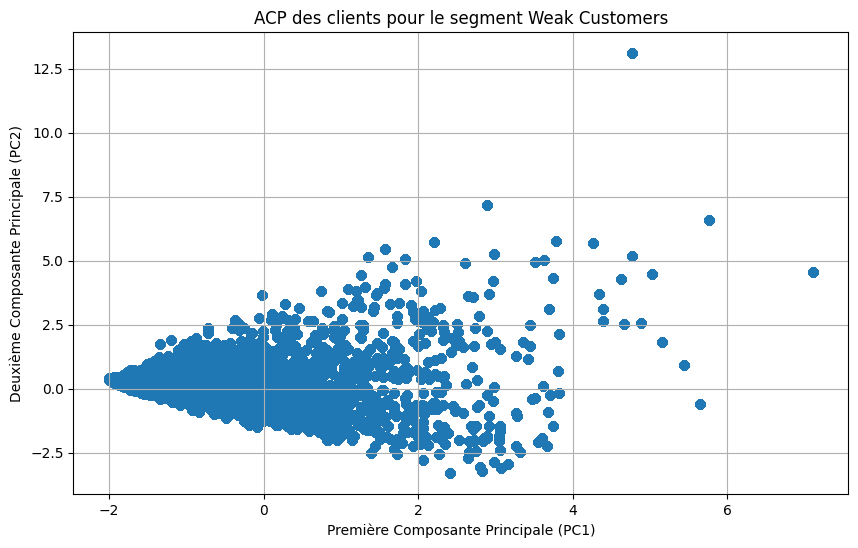

Variance expliquée par chaque composante: [0.33451885 0.21531135]
Variance totale expliquée: 0.5498302055521435

ACP pour le segment RFM : Loss of Momentum


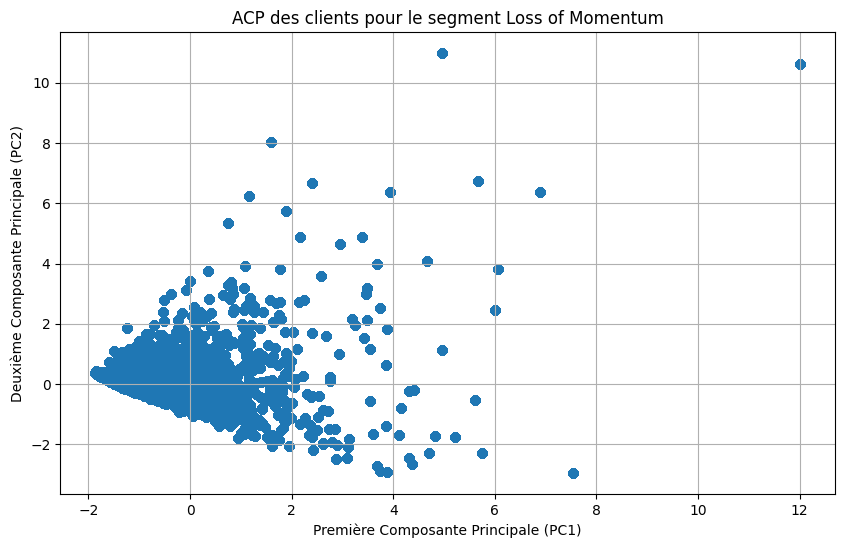

Variance expliquée par chaque composante: [0.35512349 0.17941872]
Variance totale expliquée: 0.5345422055719586


In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Pour chaque segment RFM
for segment in client_secteur_freq['Segment_RFM_x'].unique():
    print(f"\nACP pour le segment RFM : {segment}")
    
    # Filtrer les données pour le segment actuel
    segment_data = client_secteur_freq[client_secteur_freq['Segment_RFM_x'] == segment].copy()
    
    # Isoler `customer_id` avant la normalisation
    customer_ids = segment_data['customer_id']
    
    # Normaliser uniquement les colonnes nécessaires (exclure `customer_id` et `Segment_RFM_x`)
    scaler = StandardScaler()
    segment_data_scaled = scaler.fit_transform(segment_data.drop(columns=['customer_id', 'Segment_RFM_x']))
    
    # Appliquer l'ACP
    pca = PCA(n_components=2)  # Choisir 2 composantes pour la visualisation
    segment_pca = pca.fit_transform(segment_data_scaled)
    
    # Créer un DataFrame pour les résultats de l'ACP
    segment_pca_df = pd.DataFrame(segment_pca, columns=['PC1', 'PC2'])
    segment_pca_df['customer_id'] = customer_ids.values  # Ajouter `customer_id` pour référence
    
    # Visualiser les résultats de l'ACP
    plt.figure(figsize=(10, 6))
    plt.scatter(segment_pca_df['PC1'], segment_pca_df['PC2'], alpha=0.6)
    plt.title(f"ACP des clients pour le segment {segment}")
    plt.xlabel("Première Composante Principale (PC1)")
    plt.ylabel("Deuxième Composante Principale (PC2)")
    plt.grid()
    plt.show()

    # Afficher la variance expliquée
    print("Variance expliquée par chaque composante:", pca.explained_variance_ratio_)
    print("Variance totale expliquée:", pca.explained_variance_ratio_.sum())
